<a href="https://colab.research.google.com/github/hannahzafar/UMDAOSC650/blob/main/firstrnn_changes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM,Dense, Dropout, RepeatVector
import keras
from keras.src.preprocessing.sequence import TimeseriesGenerator
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# reading dataset from NOAA online
dataset = pd.read_csv(
    'http://www.cpc.ncep.noaa.gov/data/indices/oni.ascii.txt',
    delim_whitespace=True)

In [4]:
# data features include seasons, year, total SST (C), and ONI (ENSO index)
dataset.head()

,SEAS,YR,TOTAL,ANOM
0,DJF,1950,24.72,-1.53
1,JFM,1950,25.17,-1.34
2,FMA,1950,25.75,-1.16
3,MAM,1950,26.12,-1.18
4,AMJ,1950,26.32,-1.07


In [5]:
dataset.tail()

,SEAS,YR,TOTAL,ANOM
884,ASO,2023,28.32,1.56
885,SON,2023,28.49,1.78
886,OND,2023,28.60,1.92
887,NDJ,2023,28.57,1.95
888,DJF,2024,28.44,1.80


In [6]:
# drop any nans
dataset = dataset.dropna(subset=["ANOM"])

In [7]:
# quick stats
dataset.describe()

,YR,TOTAL,ANOM
count,889.000000,889.000000,889.000000
mean,1986.542182,26.900157,0.011102
std,21.397005,0.943204,0.838484
min,1950.000000,24.380000,-2.030000
25%,1968.000000,26.230000,-0.570000
50%,1987.000000,26.950000,-0.050000
75%,2005.000000,27.540000,0.530000
max,2024.000000,29.260000,2.640000


<Axes: xlabel='YR'>

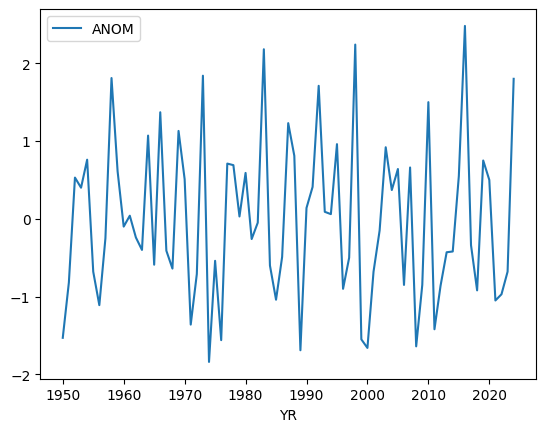

In [8]:
# quick viz
# djf only
dataset[dataset["SEAS"]=="DJF"].plot("YR","ANOM")

In [9]:
# train test split by years
trainds = dataset[dataset["YR"]<=2010]
testsds = dataset[dataset["YR"]>2010]

In [10]:
# grab anoms columns (ONI) and reset index
# reshape to be (samples, features)
# number of features here is just 1 (ONI)
trainds = trainds.reset_index(drop=True)["ANOM"].values.reshape(-1, 1)
testsds = testsds.reset_index(drop=True)["ANOM"].values.reshape(-1, 1)

In [11]:
# Feature Scaling
sc = MinMaxScaler(feature_range=(0,1))

In [12]:
# do rescaling
trainds_scaled = sc.fit_transform(trainds)
testsds_scaled = sc.transform(testsds)

In [40]:
# for help with data manipulation for time series rnn training; we can use the time series generator from keras

# dummy input for understanding
# data = np.array([[i] for i in range(50)])

# here goes our training data
data = trainds_scaled

# the shape of your target is your prediction shape (e.g., here we make it 4)
target = np.concatenate((np.roll(data, 0, axis=0),
                         np.roll(data, -1, axis=0),
                         np.roll(data, -2, axis=0),
                         np.roll(data, -3, axis=0)
                        ), axis=1)

# the length of the input feature
n_input=11
n_features=data.shape[1]

# this is the generator that will go into our rnn for training
data_gen = TimeseriesGenerator(data,
                               target,
                               length=n_input,
                               sampling_rate=1,
                               batch_size=16,
                               shuffle=False)

In [36]:
target.shape

(732, 4)

In [29]:
# quick check of output
batch_0 = data_gen[0]
x, y = batch_0
print(x[0], y[0])
print(x.shape, y.shape)

[[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]] [11 12 13 14]
(16, 11, 1) (16, 4)


In [51]:
# lets make our rnn!
regressor = Sequential()
# LSTM with just one memory state (units=1)
regressor.add(LSTM(units=100, return_sequences=True, input_shape=(n_input, n_features)))
# one neuron for output prediction
regressor.add(Dense(1))
# compile model
regressor.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])
# what does graph look like?
regressor.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 11, 100)           40800     
                                                                 
 dense_7 (Dense)             (None, 11, 1)             101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [42]:
# train the lstm!
regressor.fit(data_gen, epochs=100)

Epoch 1/100


InvalidArgumentError: Graph execution error:

Detected at node gradient_tape/mean_squared_error/BroadcastGradientArgs defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-42-797271836a18>", line 2, in <cell line: 2>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1154, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 543, in minimize

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 276, in compute_gradients

Incompatible shapes: [16,11] vs. [16,4]
	 [[{{node gradient_tape/mean_squared_error/BroadcastGradientArgs}}]] [Op:__inference_train_function_41096]

In [ ]:
d# here goes our testing data
testdata = testsds_scaled

testtarget = np.concatenate((
    np.roll(testdata, 0, axis=0),
    np.roll(testdata, -1, axis=0),
    np.roll(testdata, -2, axis=0),
    np.roll(testdata, -3, axis=0)
    ), axis=1)

testdata_gen = TimeseriesGenerator(
    testdata,
    testtarget,
    length=n_input,
    sampling_rate=1,
    batch_size=testdata.shape[0], # all samples
    shuffle=False)

In [ ]:
# quick check of output
batch_0 = testdata_gen[0]
x, y = batch_0
print(x[0], y[0])
print(x.shape, y.shape)

In [ ]:
oni_predictions = regressor.predict(testdata_gen)

In [ ]:
print(oni_predictions.shape, y[:,0].shape)

In [ ]:
# how did we do!?
leadmonth = 0
plt.scatter(
    sc.inverse_transform(y[:,leadmonth].reshape(-1, 1)),
    sc.inverse_transform(oni_predictions[:,leadmonth,0].reshape(-1, 1))
    )
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.show()

In [ ]:
# how did we do!?
leadmonth = 1
plt.scatter(
    sc.inverse_transform(y[:,leadmonth].reshape(-1, 1)),
    sc.inverse_transform(oni_predictions[:,leadmonth,0].reshape(-1, 1))
    )
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.show()

In [ ]:
# how did we do!?
leadmonth = 2
plt.scatter(
    sc.inverse_transform(y[:,leadmonth].reshape(-1, 1)),
    sc.inverse_transform(oni_predictions[:,leadmonth,0].reshape(-1, 1))
    )
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.show()

In [ ]:
# how did we do!?
leadmonth = 3
plt.scatter(
    sc.inverse_transform(y[:,leadmonth].reshape(-1, 1)),
    sc.inverse_transform(oni_predictions[:,leadmonth,0].reshape(-1, 1))
    )
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.show()